# Going Deeper(CV)
# 18. 직접 만들어보는 OCR [프로젝트]

## 18-1. 프로젝트: End-to-End OCR

### 라이브러리 버전 확인

In [2]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


### 필요한 라이브러리 준비

In [3]:
# pip install lmdb

In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

HOME_DIR = os.getenv('HOME')+'/aiffel'

TRAIN_DATA_PATH = HOME_DIR+'/ocr/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/ocr/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/ocr/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 이미지 전처리

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [6]:
class LabelConverter(object):

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
TARGET_CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### Recognition 모델 생성

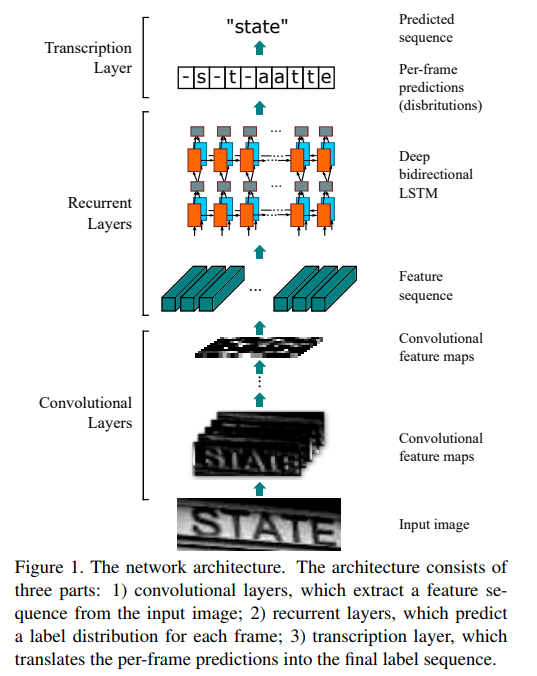

[참고 링크1](https://tw0226.tistory.com/90)

CRNN의 형태는 위와 같다고 합니다.  

CNN과 RNN의 구조를 합친 형태를 띄고 있는데, conv와 maxpool, batchnormalization을 사용하는 부분은 지금까지 수행했던 프로젝트들에서 사용하던 컨볼루션 네트워크의 형태와 유사합니다.  
RNN의 구조도 LSTM을 양방향으로 사용하고 있는 것은 케창딥에서 학습했던 부분과 비슷합니다.  

그런데 이 둘을 합치면 어떻게 문자를 인식하게 되는걸까요? 이 부분은 GPT의 정보를 참고했습니다.
- CNN을 통해 이미지의 특징을 추출
- RNN을 통해 각 문자들을 독립된 글자가 아닌 시퀀스 데이터 형태로 처리
- 이 때 LSTM을 사용하여 글자의 전후정보를 모두 활용하여 학습(양방향으로)

CNN(특징 추출) - RNN(특징 기반 추측) 이 이루어지는 것 같습니다.

In [9]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 모델 훈련

In [10]:
EPOCH = 70
LEARNING_RATE = 1e-1
BATCH_SIZE=128

train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=LEARNING_RATE, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path = HOME_DIR + f'/Going_Deeper/model_checkpoint_{EPOCH}_{str(LEARNING_RATE)}.hdf5'

# ModelCheckPoint 설정
ckp = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_weights_only=True, save_best_only=True)

# EarlyStopping 설정
earlystop = EarlyStopping(monitor='val_loss', patience=3)


history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCH,
          validation_data=val_set,
          validation_steps=len(val_set),
          # ModelCheckPoint와 EarlyStopping을 활용하는 경우 바로 아래 callbacks 옵션에 주석을 풀어주세요.
          callbacks=[ckp, earlystop]
)

history_path = HOME_DIR + f'/Going_Deeper/history_{EPOCH}_{str(LEARNING_RATE)}.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/70
565/565 [==============================] - 96s 149ms/step - loss: 25.3345 - val_loss: 23.0038
Epoch 2/70
565/565 [==============================] - 83s 147ms/step - loss: 14.4599 - val_loss: 9.6963
Epoch 3/70
565/565 [==============================] - 83s 147ms/step - loss: 7.0458 - val_loss: 6.2426
Epoch 4/70
565/565 [==============================] - 83s 146ms/step - loss: 5.1051 - val_loss: 5.4497
Epoch 5/70
565/565 [==============================] - 83s 147ms/step - loss: 4.0664 - val_loss: 4.8178
Epoch 6/70
565/565 [==============================] - 83s 146ms/step - loss: 3.3403 - val_loss: 4.3205
Epoch 7/70
565/565 [==============================] - 83s 147ms/step - loss: 2.7572 - val_loss: 4.3936
Epoch 8/70
565/565 [==============================] - 83s 146ms/step - loss: 2.2705 - val_loss: 4.3353
Epoch 9/70
565/565 [==============================] - 84s 148ms/step - loss: 1.8551 - val_loss: 4.1973
Epoch 10/70
565/565 [==============================] - 83s 147ms/step 

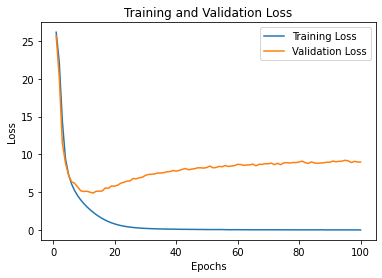

In [13]:
# pickle 파일 로드하여 학습 히스토리 가져오기
history_path = HOME_DIR + f'/Going_Deeper/history_{100}_{str(0.05)}.pkl'
with open(history_path, 'rb') as f:
    training_history = pickle.load(f)

# 학습과 검증 손실 값 추출
train_loss = training_history['loss']
val_loss = training_history['val_loss']

# 학습과 검증 손실 그래프 그리기
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

0.05의 학습률로 100에포크를 돌려봤습니다.  
15에포크쯤 언저리에서 과적합이 일어났음을 확인할 수 있습니다.  

EarlyStopping을 사용하여 다시 모델을 학습합니다.

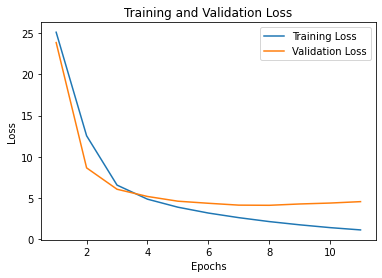

In [21]:
# pickle 파일 로드하여 학습 히스토리 가져오기
# history_path = HOME_DIR + f'/Going_Deeper/history_{EPOCH}_{str(LEARNING_RATE)}.pkl'
with open(history_path, 'rb') as f:
    training_history = pickle.load(f)

# 학습과 검증 손실 값 추출
train_loss = training_history['loss']
val_loss = training_history['val_loss']

# 학습과 검증 손실 그래프 그리기
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

8에포크쯤이 가장 검증 손실이 적은 것을 확인할 수 있습니다.  

한 가지 특이점은 학습률을 0.05로 설정하면 검증 손실이 5.x정도의 값에 머물지만, 학습률을 0.1로 설정하면 검증 손실이 4.x까지 내려간다는 점입니다.  

아마 0.05의 학습률을 설정하면 안장점에 머무르다가 과적합이 일어나는 것이 아닐까 추측해봅니다.

### 결과 확인

In [13]:
# checkpoint_path = HOME_DIR + f'/Going_Deeper/model_checkpoint_{EPOCH}_{str(LEARNING_RATE)}.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


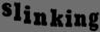

Result: 	 ALEPPO


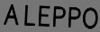

Result: 	 RWNDE


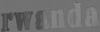

Result: 	 NATHANS


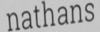

Result: 	 HALBO


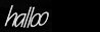

Result: 	 HURLS


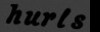

Result: 	 DOWNSIZE


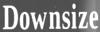

Result: 	 ROBOTIC


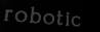

Result: 	 SLOPPY


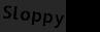

Result: 	 HERMITE


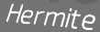

In [14]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result.replace('0',''))
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

RWNDE, HALBO와 같이 결과가 정답과 비슷하지만 아쉬운 것들이 보입니다.  

하지만 전체적으로는 인식이 잘 되었습니다. ALEPPO, SLOPPY처럼 같은 문자가 중복되는 경우도 잘 인식됩니다.

## 샘플 이미지를 받아 OCR 수행하기

### 파일 불러오기

In [27]:
HOME_DIR = os.getenv('HOME')+'/aiffel'
SAMPLE_IMG_PATH = HOME_DIR + '/ocr/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


### 이미지에서 문자 영역 검출

In [28]:
# 문자 인식 함수
def detect_text(img_path):
    # cv2로 이미지 불러오기
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_batch = np.expand_dims(img_rgb, axis=0) # 배치 차원 추가
    
    # keras ocr 수행
    ocr_result = detector.detect(img_batch)[0] # 첫 번째 결과만 가져오기
    
    # 시각화를 위해 ImageDraw 사용
    img_pil = Image.fromarray(img_rgb)
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)
    
    # 인식된 부분만 잘라낸 이미지들을 저장할 리스트
    cropped_imgs = []
    
    # 이미지 잘라내기
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))
        
    return result_img, cropped_imgs

# 결과 시각화 함수
def show_images(img, cropped_imgs):
    total_images = len(cropped_imgs) + 1
    plt.figure(figsize=(10, 10 * total_images))
    
    # 원본 이미지 표시
    plt.subplot(total_images, 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # 잘라낸 이미지들 표시
    for i, cropped_img in enumerate(cropped_imgs):
        plt.subplot(total_images, 1, i + 2)
        plt.imshow(cropped_img)
        plt.title(f'Cropped Image {i + 1}')
        plt.axis('off')
    
    plt.show()

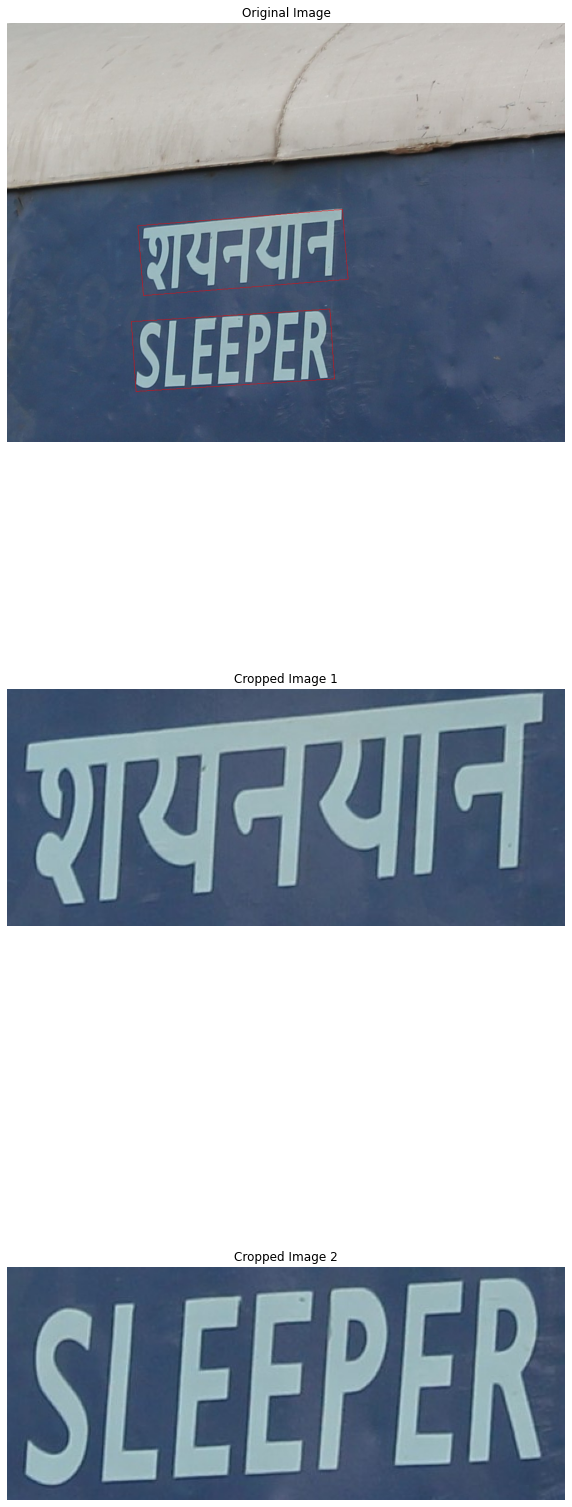

In [29]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
show_images(img_pil, cropped_img)

1. 원본 이미지에서 문자로 인식된 부분에 빨간 바운딩 박스가 올바르게 처리된 것을 확인할 수 있습니다.
2. 바운딩 박스를 기준으로 문자로 인식된 부분만 crop한 이미지들을 확인할 수 있습니다.

굳이 detector를 사용하는 이유는 뭘까요?  
이유는 원본 이미지에서 글자 영역을 찾기가 완전 불가능은 아니지만 처리 시간, 계산 효율 등의 비용 면에서 너무 비효율적이기 때문에 관심 영역을 미리 찾아 지정하고 이 곳에서 단어를 인식하는 것이 더 좋기 때문입니다.  

[참고 링크2](https://medium.com/@msmapark2/character-region-awareness-for-text-detection-craft-paper-%EB%B6%84%EC%84%9D-da987b32609c)

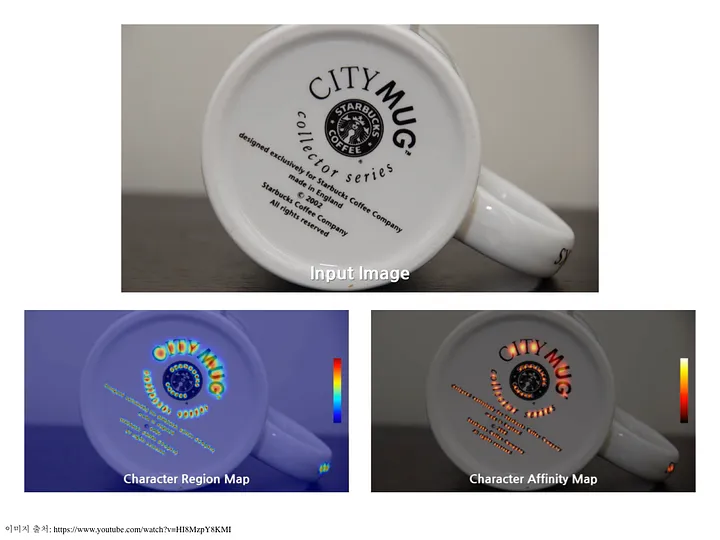

keras ocr에서 craft를 사용하는 것 같은데 이를 사용하는 이유는 craft 단어의 연속성, 외곽선 등(폰트, 자간, 공백 크기 등)을 인식하는데 있어서 성능이 뛰어나기 때문입니다.  
- craft는 글자의 가운데 영역을 기준으로 가우시안 분포를 그립니다. > 한 글자가 어디까지인지를 알 수 있습니다.(폰트 등을 통해 이미지에 왜곡이 있는 경우를 대응 가능)
- craft는 글자 사이의 자간을 기준으로도 가우시안 분포를 그립니다. > 한 단어가 어디까지인지를 알 수 있습니다.(공백이 크면 서로 다른 단어, 공백이 작으면 같은 단어)

### 검출된 문자 이미지를 모델을 통해 inference

In [36]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def recognize_img(_model, pil_img, input_img_size=(100, 32)):
    # 이미지의 세로를 32로, 가로를 원본 이미지의 비율에 맞춰서 변경(최대 100)
    width, height = pil_img.size    
    target_width = min(int(width*input_img_size[1]/height), input_img_size[0])
    target_img_size = (target_width, input_img_size[1])
    pil_img = np.array(pil_img.resize(target_img_size)).transpose(1,0,2) # transpose를 하는 이유는 display를 사용할 때 x, y를 뒤바꿔
                                                                         # 사용하기 때문에 모델도 이에 맞춰 input을 받기 때문입니다.
    # 이미지의 가로의 길이가 100보다 작을 경우 빈 공간을 0으로 메꿔줍니다.
    if target_width < 100:
        new_img = np.zeros((input_img_size[0], input_img_size[1], 3), dtype=np.uint8)
        new_img[:target_width, :, :] = pil_img
        pil_img = new_img

    # 모델의 입력으로 사용할 수 있도록 축을 추가합니다.
    processed_image = np.expand_dims(pil_img, axis=0)

    # 모델의 입력 데이터를 정의합니다.
    input_data = _model.get_layer('input_image').output
    y_pred = _model.get_layer('output').output

    # inference 전용 모델을 만듭니다.
    model_pred = Model(inputs=input_data, outputs=y_pred)
    
    output = model_pred.predict(processed_image)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result.replace('0',''))
    display(Image.fromarray(processed_image[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 UFTUF


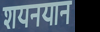

Result: 	 SLEEPER


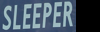

In [33]:
# inference 모델 불러오기
# checkpoint_path = HOME_DIR + f'/Going_Deeper/model_checkpoint_{EPOCH}_{str(LEARNING_RATE)}.hdf5'
model = build_crnn_model()
model.load_weights(checkpoint_path)

for _img in cropped_img:    
    recognize_img(model, _img)

영어가 아닌 언어도 영어로 인식하는 것을 확인할 수 있습니다..ㅋㅋ  

SLEEPER는 제대로 인식됩니다. E가 중복되는 것도 정확히 인식했습니다.

### 다른 이미지에도 적용해보기

문자가 많이 있는 이미지를 한 번 찾아봤습니다.

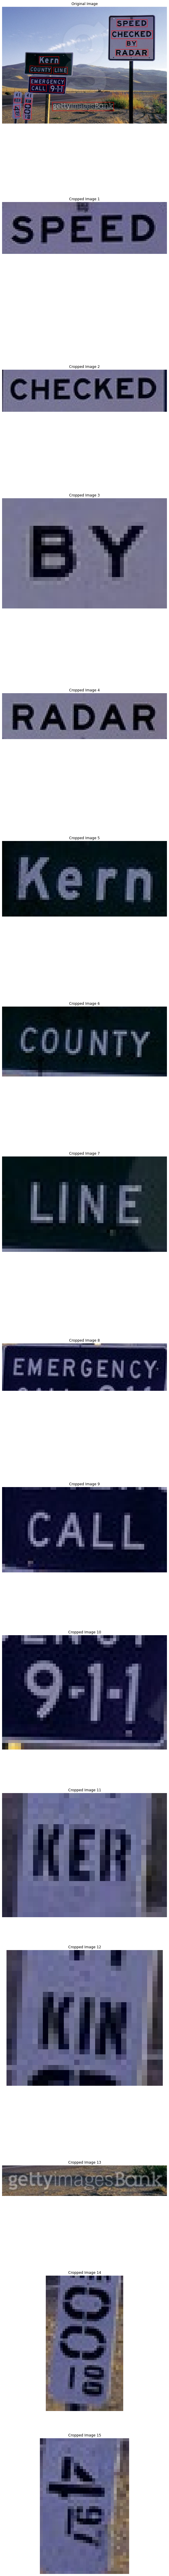

Result: 	 SPED


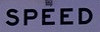

Result: 	 CHECKED


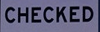

Result: 	 BY


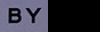

Result: 	 RADAR


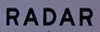

Result: 	 KERN


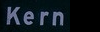

Result: 	 COUNTY


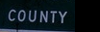

Result: 	 LINE


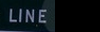

Result: 	 EMERGENCY


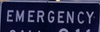

Result: 	 CALL


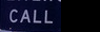

Result: 	 ELS


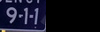

Result: 	 KEB


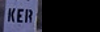

Result: 	 KR


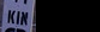

Result: 	 GETYMPSATONK


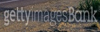

Result: 	 G


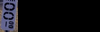

Result: 	 E


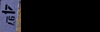

In [37]:
HOME_DIR = os.getenv('HOME')+'/aiffel'
SAMPLE_IMG_PATH = HOME_DIR + '/Going_Deeper/sample2.jpg'

img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
show_images(img_pil, cropped_img)

for _img in cropped_img:    
    recognize_img(model, _img)

정확히 인식한 것과 아닌 것이 섞여있습니다. 결과를 정리하자면
1. 글자 크기가 작을수록(픽셀이 작을수록) 인식이 힘들어진다.
    - 어찌 보면 당연한 것 같습니다. KEB의 예시를 보면 원본 이미지의 글자가 KER인지 KEB가 살짝 지워진건지 육안으로 보기에도 애매한 것을 확인할 수 있습니다. 그리고 이를 crop한 이미지를 확인해보면(Cropped Image 11) 낮은 해상도로 인해 더욱 구별이 힘든 것을 확인할 수 있습니다.
2. 숫자를 인식하지 못한다.
    - 처음엔 MJSynth 데이터에 숫자 포함된 데이터가 없다고 생각했습니다. 하지만 TARGET_CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"로 변경하면 모델 학습 단계에서 오류가 발생합니다. 그 내용은 훈련 데이터셋에서 비어있는 것이 있다는 내용이었습니다. 즉, 숫자 이미지 데이터가 있는데 이것이 변환되지 않아 비어있다는 의미인데, 이는 곧 숫자 데이터가 훈련 데이터에 존재함을 의미했습니다.
    - 그렇다면 어째서 숫자를 인식하지 못하는 걸까요? ...이 이유는 아직 알아내지 못했습니다..
3. (위의 결과로는 확인할 수 없지만)세로로 된 문자를 인식하지 못한다.
    - 옆으로 누워있든 세로로 써있는 문자든 인식하지 못할 것입니다. 학습 데이터는 전부 가로로 된 글자였기 때문입니다.
4. 단어의 길이가 인식률과 연관이 있다.
    - 단어가 너무 길면 문자인식 성능이 떨어집니다. 이미지가 (32, 100)이라는 크기로 변경되면 긴 단어 이미지는 글씨가 세로로 길쭉하게 찌그러지기 때문입니다. 이미지는 이런 형태의 단어를 학습한 적이 없기 때문에 인식을 못하게 됩니다.
    - 단어 길이가 달라지며 생기는 또다른 문제는 글자 길이 자체를 처리하는데 있어서도 발생합니다. 모델이 학습하는 과정에서 단어의 길이가 너무 짧으면 남은 공간을 0으로 처리하여 학습하는데 이 때 파라미터들이 0을 학습하는데 낭비되고 과적합되는 문제가 발생합니다. 반대로 단어의 길이가 너무 길면 아예 학습을 못할 수도 있습니다...
    - 자연어 처리에서 배웠던 패딩, 마스킹 등의 기술들을 활용하면 이를 해결할 수 있으며, 애초에 너무 긴 단어같은 경우는 자주 등장하지 않는 데이터이므로 이상치로 판단하여 학습에서 제거할 수도 있습니다.

### 추가 실험

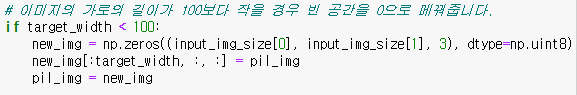

빈 공간을 메꿔주는 이유에 대한 설명입니다.

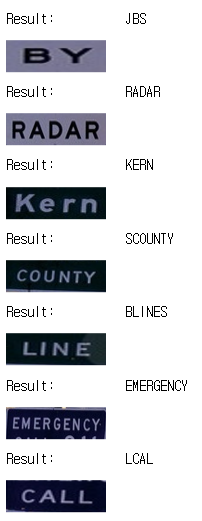

단어 이미지의 빈 공간을 메꾸지 않으면 위와 같은 문제가 발생합니다.  
이는 이미지를 학습할 때 가로로 길게 늘려지거나 세로로 압축된 단어를 학습하지 않기 때문입니다. 특히 BY, LINE, CALL의 경우 결과가 특히 이상하게 나오는 것을 확인할 수 있습니다.

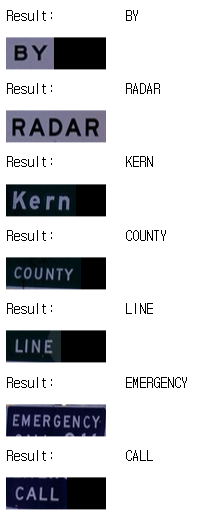

이는 수정했을 때의 결과입니다.